In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
# pip install tabulate
# !pip install uncertainties

In [3]:
# вывод таблиц
from tabulate import tabulate

from uncertainties import ufloat

# тепловая карта:
from seaborn import heatmap as ht

# отключение предупреждений
import warnings
warnings.simplefilter("ignore")

In [4]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


In [5]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# # репрезентация данных в виде графиков
# g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# # plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)


In [6]:
### Шаг 3. Обученние нейронной сети

# скорость обучения (learning rate)
# число нейронов скрытого слоя (neuron_numb)
# количество эпох (eras_numb)

def neural_network_training_and_test (neuron_numb = 5, eras_numb = 100, n = 0.05):
    # присваивание случайных весов
    
    w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, 3 выхода
    w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода
    
    # массив для ошибок, чтобы потом построить график
    errors = []
    
    # процесс обучения
    for i in range(eras_numb):
        
        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2)
    
        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)
    
        # коррекция
        w1 += layer1.T.dot(layer2_delta) * n
        w0 += layer0.T.dot(layer1_delta) * n
        
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
        
    # прямое распространение(feed forward)
    layer0_t = X_test
    layer1_t = sigmoid(np.dot(layer0_t, w0))
    layer2_t = sigmoid(np.dot(layer1_t, w1))
    layer2_error_t = y_test - layer2_t
        
    # метрика модели
    error_t = np.mean(np.abs(layer2_error_t))
    accuracy_t = (1 - error_t) * 100
        
    return (accuracy, accuracy_t)

In [7]:
# набор значений для числа нейронов
neuron_numb_values = [5, 10, 50, 150, 500]

# набор значений для числа эпох
eras_numb_values = [50, 100, 300, 500]

# набор значений для задания скорости обучения
learning_rate_values = [0.5, 0.1, 0.05, 0.01, 0.003]

max_a = []
max_at = []
best_n_n = 0
best_e_n = 0
best_l_n = 0

value_list_1step = []

# подбор параметров
for n_n in neuron_numb_values:
    for e_n in eras_numb_values:
        for l_n in learning_rate_values:
            result_tab = pd.DataFrame(columns=["\"Accuracy\"", "\"Accuracy\" for Test"])
            for exp_step in range(20):
                result = neural_network_training_and_test (n_n, e_n, l_n)
                result_tab = result_tab.append({"\"Accuracy\"": result[0], "\"Accuracy\" for Test": result[1]}, ignore_index=True)
            m_value_1 = result_tab["\"Accuracy\""].mean()
            d_value_1 = result_tab["\"Accuracy\""].std()
            m_value_2 = result_tab["\"Accuracy\" for Test"].mean()
            d_value_2 = result_tab["\"Accuracy\" for Test"].std()
            value_list_1step.append([n_n, e_n, l_n, m_value_1])
            if  ([m_value_1-3*np.sqrt(d_value_1), m_value_1+3*np.sqrt(d_value_1)] > max_a) & ([m_value_2-3*np.sqrt(d_value_2), m_value_2+3*np.sqrt(d_value_2)] > max_at):
                max_a = [m_value_1-3*np.sqrt(d_value_1), m_value_1+3*np.sqrt(d_value_1)]
                max_at = [m_value_2-3*np.sqrt(d_value_2), m_value_2+3*np.sqrt(d_value_2)]
                best_n_n = n_n
                best_e_n = e_n
                best_l_n = l_n

In [8]:
print('Bounds for \'accuracy\' for training (best result):', max_a)
print('Bounds for \'accuracy\' for test (best result):', max_at)
print('Best parameters:')
print('best number of neurons =', best_n_n)
print('best number of eras =', best_e_n)
print('best learning rate =', best_l_n)

Bounds for 'accuracy' for training (best result): [88.4637590079629, 95.06816225374023]
Bounds for 'accuracy' for test (best result): [90.6928401063526, 97.80267051114166]
Best parameters:
best number of neurons = 5
best number of eras = 500
best learning rate = 0.5


In [9]:
value_list_1step = sorted(value_list_1step, key=lambda value: value[3], reverse=True)
column_list = ["Number of Neurons", "Number of Eras", "Learning rate", "Mean value of \"Accuracy\""]
result_1step_pd = pd.DataFrame(data=value_list_1step, columns=column_list)

In [10]:
result_1step_pd = result_1step_pd.set_index('Number of Eras')

In [11]:
pd.pivot_table(result_1step_pd,
               index=["Number of Eras"],
               columns=["Number of Neurons", "Learning rate"],
               values=["Mean value of \"Accuracy\""])

Mean value of "Accuracy"                                   \
Number of Neurons                      5                                      
Learning rate                        0.003      0.010      0.050      0.100   
Number of Eras                                                                
50                               53.934753  55.823980  59.779237  68.966239   
100                              55.438421  56.188643  68.947919  74.514375   
300                              56.213949  60.677496  76.976759  81.033030   
500                              56.845683  69.050383  79.500102  86.989548   

                                                                          \
Number of Neurons                   10                                     
Learning rate          0.500      0.003      0.010      0.050      0.100   
Number of Eras                                                             
50                 76.252993  55.225336  56.227549  61.530479  71.233590   
100                79.333023  55.862786  56.787551  71.569108  75.571615   
300                86.237100  56.752330  65.025630  77.842454  81.684952   
500                91.765961  58.198281  71.132558  80.956599  88.353594   

                              ...                                              \
Number of Neurons             ...        150                                    
Learning rate          0.500  ...      0.003      0.010      0.050      0.100   
Number of Eras                ...                                               
50                 75.481806  ...  57.350765  62.479577  66.608015  61.046518   
100                78.608378  ...  60.973983  67.694122  66.666165  64.001349   
300                86.532153  ...  66.350704  73.554103  66.666031  64.400837   
500                91.805151  ...  70.461580  75.697345  66.666413  64.933241   

                                                                          \
Number of Neurons                   500                                    
Learning rate          0.500      0.003      0.010      0.050      0.100   
Number of Eras                                                             
50                 57.233327  58.270084  64.312648  59.205642  58.866617   
100                55.033343  65.722959  63.789443  61.166552  53.666544   
300                52.699982  69.369935  62.802161  59.999607  55.366630   
500                54.199998  68.000402  64.952620  58.268935  53.666647   

                              
Number of Neurons             
Learning rate          0.500  
Number of Eras                
50                 50.466719  
100                54.133344  
300                52.833333  
500                54.600001  

[4 rows x 25 columns]

In [12]:
result_heatmap_1 = result_1step_pd[["Number of Neurons", "Learning rate", "Mean value of \"Accuracy\""]]
result_heatmap_1 = pd.pivot_table(result_heatmap_1,
                                  index=["Number of Eras"],
                                  columns=["Number of Neurons", "Learning rate"],
                                  values=["Mean value of \"Accuracy\""])

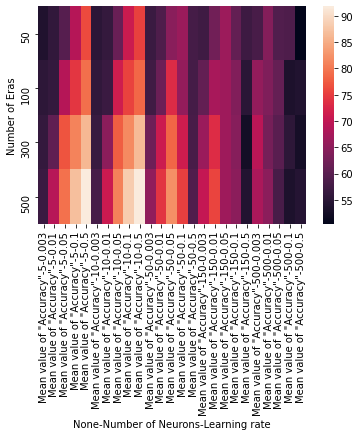

In [13]:
ax_1 = ht(result_heatmap_1)

#### Повторение отбора:

In [15]:
# в окрестностях лучших повторим подбор:

# набор значений для числа нейронов
neuron_numb_values = [3, 5, 6, 7, 8, 9]

# набор значений для числа эпох
eras_numb_values = [500, 1000, 2000, 4000]

# набор значений для задания скорости обучения
learning_rate_values = [0.001, 0.3, 0.5, 0.6]

max_a = []
max_at = []
best_n_n = 0
best_e_n = 0
best_l_n = 0

value_list_2step = []

# подбор параметров
for n_n in neuron_numb_values:
    for e_n in eras_numb_values:
        for l_n in learning_rate_values:
            result_tab = pd.DataFrame(columns=["\"Accuracy\"", "\"Accuracy\" for Test"])
            for exp_step in range(10):
                result = neural_network_training_and_test (n_n, e_n, l_n)
                result_tab = result_tab.append({"\"Accuracy\"": result[0], "\"Accuracy\" for Test": result[1]}, ignore_index=True)
            m_value_1 = result_tab["\"Accuracy\""].mean()
            d_value_1 = result_tab["\"Accuracy\""].std()
            m_value_2 = result_tab["\"Accuracy\" for Test"].mean()
            d_value_2 = result_tab["\"Accuracy\" for Test"].std()
            value_list_2step.append([n_n, e_n, l_n, m_value_1])
            if  ([m_value_1-3*np.sqrt(d_value_1), m_value_1+3*np.sqrt(d_value_1)] > max_a) & ([m_value_2-3*np.sqrt(d_value_2), m_value_2+3*np.sqrt(d_value_2)] > max_at):
                max_a = [m_value_1-3*np.sqrt(d_value_1), m_value_1+3*np.sqrt(d_value_1)]
                max_at = [m_value_2-3*np.sqrt(d_value_2), m_value_2+3*np.sqrt(d_value_2)]
                best_n_n = n_n
                best_e_n = e_n
                best_l_n = l_n

In [16]:
print('Bounds for \'accuracy\' for training (best result):', max_a)
print('Bounds for \'accuracy\' for test (best result):', max_at)
print('Best parameters:')
print('best number of neurons =', best_n_n)
print('best number of eras =', best_e_n)
print('best learning rate =', best_l_n)

Bounds for 'accuracy' for training (best result): [95.73288425544743, 98.08012468346229]
Bounds for 'accuracy' for test (best result): [95.75001023069908, 99.65162421303151]
Best parameters:
best number of neurons = 6
best number of eras = 4000
best learning rate = 0.6


In [17]:
value_list_2step = sorted(value_list_2step, key=lambda value: value[3], reverse=True)
column_list = ["Number of Neurons", "Number of Eras", "Learning rate", "Mean value of \"Accuracy\""]
result_2step_pd = pd.DataFrame(data=value_list_2step, columns=column_list)

In [18]:
result_2step_pd = result_2step_pd.set_index('Number of Eras')

In [19]:
pd.pivot_table(result_2step_pd,
               index=["Number of Eras"],
               columns=["Number of Neurons", "Learning rate"],
               values=["Mean value of \"Accuracy\""])

Mean value of "Accuracy"                                   \
Number of Neurons                        3                                    
Learning rate                        0.001      0.300      0.500      0.600   
Number of Eras                                                                
500                              55.140043  90.569882  90.749940  88.907378   
1000                             55.880907  95.574633  95.853830  95.951286   
2000                             56.426495  96.380183  96.669887  96.670882   
4000                             63.153151  96.876981  96.978476  96.901778   

                                                                          \
Number of Neurons          5                                           6   
Learning rate          0.001      0.300      0.500      0.600      0.001   
Number of Eras                                                             
500                55.906911  91.660344  91.823876  91.793683  56.010579   
1000               56.072586  95.642699  96.075663  96.185194  56.592272   
2000               58.288765  96.594283  96.690958  96.760726  59.236225   
4000               66.148374  97.041811  97.034707  97.039926  68.150145   

                              ...                                              \
Number of Neurons             ...          7                     8              
Learning rate          0.300  ...      0.500      0.600      0.001      0.300   
Number of Eras                ...                                               
500                91.771403  ...  92.237940  91.945248  56.051053  91.669918   
1000               95.746865  ...  96.125407  96.128067  56.526664  95.671189   
2000               96.598837  ...  96.764334  96.738994  59.051114  96.546488   
4000               97.036263  ...  97.034276  96.991826  68.182504  97.019812   

                                                                          \
Number of Neurons                                9                         
Learning rate          0.500      0.600      0.001      0.300      0.500   
Number of Eras                                                             
500                92.143067  92.398962  56.273961  91.453634  91.811175   
1000               95.859416  96.179681  57.172760  95.810885  96.054245   
2000               96.779533  96.726022  59.657038  96.622456  96.667754   
4000               96.956253  97.055140  68.873665  97.026227  97.052869   

                              
Number of Neurons             
Learning rate          0.600  
Number of Eras                
500                91.716265  
1000               96.250538  
2000               96.734154  
4000               96.979864  

[4 rows x 24 columns]

In [20]:
result_heatmap_2 = result_2step_pd[["Number of Neurons", "Learning rate", "Mean value of \"Accuracy\""]]
result_heatmap_2 = pd.pivot_table(result_heatmap_2,
                                  index=["Number of Eras"],
                                  columns=["Number of Neurons", "Learning rate"],
                                  values=["Mean value of \"Accuracy\""])

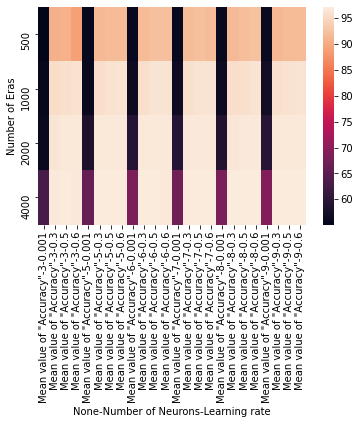

In [21]:
ax_2 = ht(result_heatmap_2)

### Вывод:

К улучшению точности нейронной сети приводит увеличение количества эпох. Что касается двух других настраиваемых мною параметров (количество нейронов и скорость обучения), предугадать лучшее значение сложнее, так как они больше зависели друг от друга и от количества эпох, но при большом количестве эпох, скорость обучения можно брать достаточно высокую (от 0.3 до 0.6), а количество нейронов на точность влияет очень слабо (что видно по тепловой карте).
Также, по тепловой карте видно, что при большом количестве эпох выше вероятность получения высокого значения точности.